# Non-linearly separable SVM with CVXOPT

## Introduction
This notebook is an implementation of Support Vector Machine in a non-linearly separable data. I used CVXOPT to the dual form of the slacked optimization problem.

I created a python class 'SVM' that stores parameters like w and b. The fit() function actually trains the SVM and plot() function plots the training examples and the generated hypterplane.

In [3]:

# File Name: script01.py
# Last Updated: Feb 22, 2018
# Purpose:
# Implementation of slacked SVM with CVXOPT

import numpy as np
import matplotlib.pyplot as plt
# We cannot use numpy's arrays in CVXOPT, so we have to
# convert these arrays into CVXOPT's own matrix type.
from cvxopt import matrix
from cvxopt import solvers

class SVM :
    def __init__ ( self, C, fig_plot = True ) :
        self.C = C
        self.fig_plot = fig_plot

    def fit ( self, x, y ) :
        P, q, G, h, A, b = svm.cvxopt_formatter ( x, y )
        self.lmdas = \
          self.cvx_optimize ( P, q, G, h, A, b ) # ( num_data * 2, 1 )
        self.w = self.lmdas_to_w ( x, y )
        # Examples that have positive values of lmda are support vectors.
        self.svecs =  self.lmdas > 1e-4
        # Among the support vectors, non-margin supoport vectors are those
        # that have lmda = C. When the training examples are linearly
        # separable, there will be no non-margin support vectors. That
        # lmdas are less than or equals C is guranteed from the constraint
        # of the dual problem.
        tol = 1e-4 # Erorr toerance
        self.nmargsv = \
          np.logical_and ( self.lmdas > self.C - tol, self.svecs )
        self.margsv = np.logical_and ( self.svecs, self.lmdas < self.C - tol )
        self.b = self.lmdas_to_b ( x, y )

        if self.fig_plot :
            plt.close ()
            self.plot ( x, y )


    def cvxopt_formatter ( self, x, y ) :
        # takes the trainig data as argumentsa and returns matrices and
        # vectors that CVXOPT can handle. We have to convert the mathematical
        # form of the dual problem into the CVXOPT's general form.
        NUM = len ( y )
        # y [ :, None ] is the column vector of y.
        M = x * y [ :, None ] # <-( NUM, 2 )
        P =  M.dot ( M.T ) # <-( NUM, 2 )
        q = - np.ones ( NUM )
        G = np.concatenate ( ( - np.identity ( NUM ), np.identity ( NUM ) ),
                             axis = 0 )
        h = np.ones ( NUM * 2 ) * self.C
        h [ : NUM ] = 0
        A = y.reshape ( 1, NUM )
        b = np.zeros ( 1 )
        return matrix ( P ), matrix ( q ), matrix ( G ),\
               matrix ( h ), matrix ( A ), matrix ( b )

    def cvx_optimize ( self, P, q, G, h, A, b ) :
        # soves the quadratic programming with solvers(), and calculates
        # w and b
        solvers.options [ 'show_progress' ] = False
        sol = solvers.qp ( P, q, G, h, A, b )
        lmdas = np.array ( sol [ 'x' ] ) # <-( num_data * 2, 1 )
        return lmdas.reshape ( -1 )

    def lmdas_to_w ( self, x, y ) :
        w = np.sum ( x * y [ :, None ] * \
            self.lmdas.reshape ( -1, 1 ), axis = 0 )
        return w # <-( , 2 )

    def lmdas_to_b ( self, x, y ) :
        # extract the margin support vectors
        msv_x = ( x.T ) [ :, self.margsv ].T
        msv_y = y [ self.margsv ]
        # msv_x <-( the number of margin sv, 2 )
        # self.w <-( 1, 2 )
        b = self.w.dot ( msv_x.T ) - msv_y
        # b can be derived from the constraint of the primal problem. At the
        # margin support vectors, the values of thier slack variables are
        # zero, so the functional margins of them must be greater than or
        # equals 1. From that, the uppor bounds of b for the Class+1 and
        # the lower bounds for the Class-1 are drived as in the above
        # equation.
        # However you will see that the calculated bouns all have the same
        # value. This means that there is no freedom of choice for the value
        # of b, and this value makes the functional margins of the margin
        # support vectors exactly 1, that is, the KKT conditions are
        # satisfied.
        return b  # <-( ,the number of svs )


    def plot ( self, x, y ) :
        ### plot the training examples
        x1 = x [ y == -1 ]
        x2 = x [ y == +1 ]
        plt.close ()
        fig1 = plt.figure ( figsize = ( 10, 8 ), facecolor = 'w',
                            edgecolor = 'k' )
        ax1 = fig1.add_subplot ( 111 )
        ax1.scatter ( x1 [ :, 0 ], x1 [ :, 1 ],
                      c = 'blue', label = 'Class-1' )
        ax1.scatter ( x2 [ :, 0 ], x2 [ :, 1 ],
                      c = 'red', label = 'Class+1' )
        # plt.legend ( loc = 2 )

        ### plot the decision boundary and the margin lines
        t = np.array ( [ 0.0, 3.0 ] )
        slope = - self.w [ 0 ] / self.w [ 1 ]
        intercept_db =  self.b [ 0 ] / self.w [ 1 ]
        intercept_mlu = ( self.b [ 0 ] + 1 ) / self.w [ 1 ]
        intercept_mll = ( self.b [ 0 ] - 1 ) / self.w [ 1 ]
        ax1.plot ( t, slope * t + intercept_db, 'k-' )
        ax1.plot ( t, slope * t + intercept_mlu, 'k--' )
        ax1.plot ( t, slope * t + intercept_mll, 'k--' )

        ### mark margin support vectors with orange plus mark
        ax1.scatter ( x [ :, 0 ][ self.margsv ], x [ :, 1 ][ self.margsv ],
                      c = 'orange', marker = '+', s = 200,
                      label = 'margin support vecotrs' )
        ### mark non-margin support vectors with green plus mark
        ax1.scatter ( x [ :, 0 ][ self.nmargsv ], x [ :, 1 ][ self.nmargsv ],
                      c = 'green', marker = '+', s = 200,
                      label = 'non-margin support vectors' )
        plt.legend ( loc = 2 )
        plt.show ()
        fig1.savefig ( 'fig1_script01.pdf' )

def example_generator () :
    # We use np.random.multivariate_normal to
    # generate n-dimentional gaussian distribution. In this example, we
    # use two-dimentional data as a training data. So 'mean' is a tow-
    # dimentional vector that specifis the coordinate of the center point
    # of the distibution. 'cvmat' is a covariance matrix. In this example,
    # we only use its diagonal elements to specify the variance of the
    # data for each axis.

    # the number of data for each class.
    num_data = 30
    x1_mean = np.array ( [ 1.0, 1.0 ] )
    x2_mean = np.array ( [ 3.0, 4.0 ] )
    x1_cvmat = np.array ( [ [ 0.6, 0.0 ],
                            [ 0.0, 0.6 ] ] )
    x2_cvmat = np.array ( [ [ 0.6, 0.0 ],
                            [ 0.0, 0.6 ] ] )
    y1 = np.ones ( num_data ) * ( + 1.0 )
    y2 = np.ones ( num_data ) * ( - 1.0 )
    # the data for the Class+1
    x1_data = np.random.multivariate_normal ( x1_mean, x1_cvmat, num_data )
    # the data for the Class-1
    x2_data = np.random.multivariate_normal ( x2_mean, x2_cvmat, num_data )
    x = np.concatenate ( ( x1_data, x2_data ), axis = 0 ) # ( num_data * 2, 2 )
    y = np.concatenate ( ( y1, y2 ), axis = 0 ) # ( num_data * 2, 1 )
    return x, y



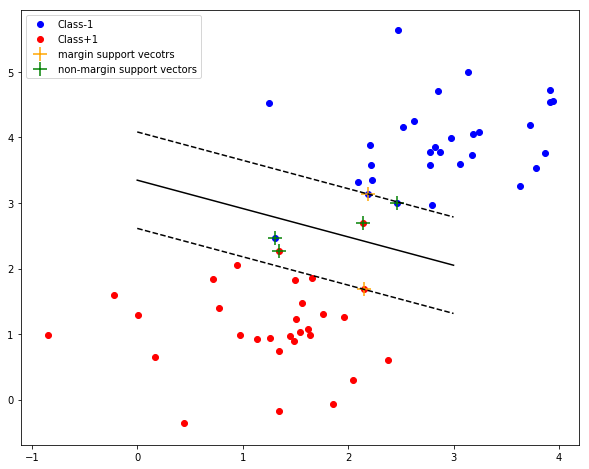

In [4]:
# Generate two-dimentional training data. 
# You can change its parameters such as mean, covariance matrix,
# and the number of training data. When the number of the 
# training data is small, the generated data may not become linearly
# non-separable. 
x, y = example_generator ()
svm = SVM ( C = 2.0, fig_plot = True )
svm.fit ( x, y )